In [1]:
!pip install Augmentor
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/871.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/871.7 kB ? eta -:--:--
   ------------ --------------------------- 262.1/871.7 kB ? eta -:--:--
   ------------------------ --------------- 524.3/871.7 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 871.7/871.7 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

In [4]:
extract_path = r'C:\Users\ADMIN\Downloads\Brain Tumor labeled dataset'

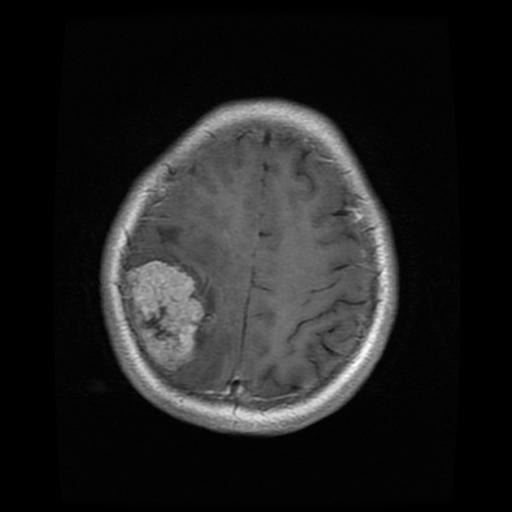

In [7]:
from PIL import Image
from IPython.display import display

# Open the image
sample_image = Image.open('C:/Users/ADMIN/Downloads/Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')

# Display the image
display(sample_image)


In [8]:
sample_image.size

(512, 512)

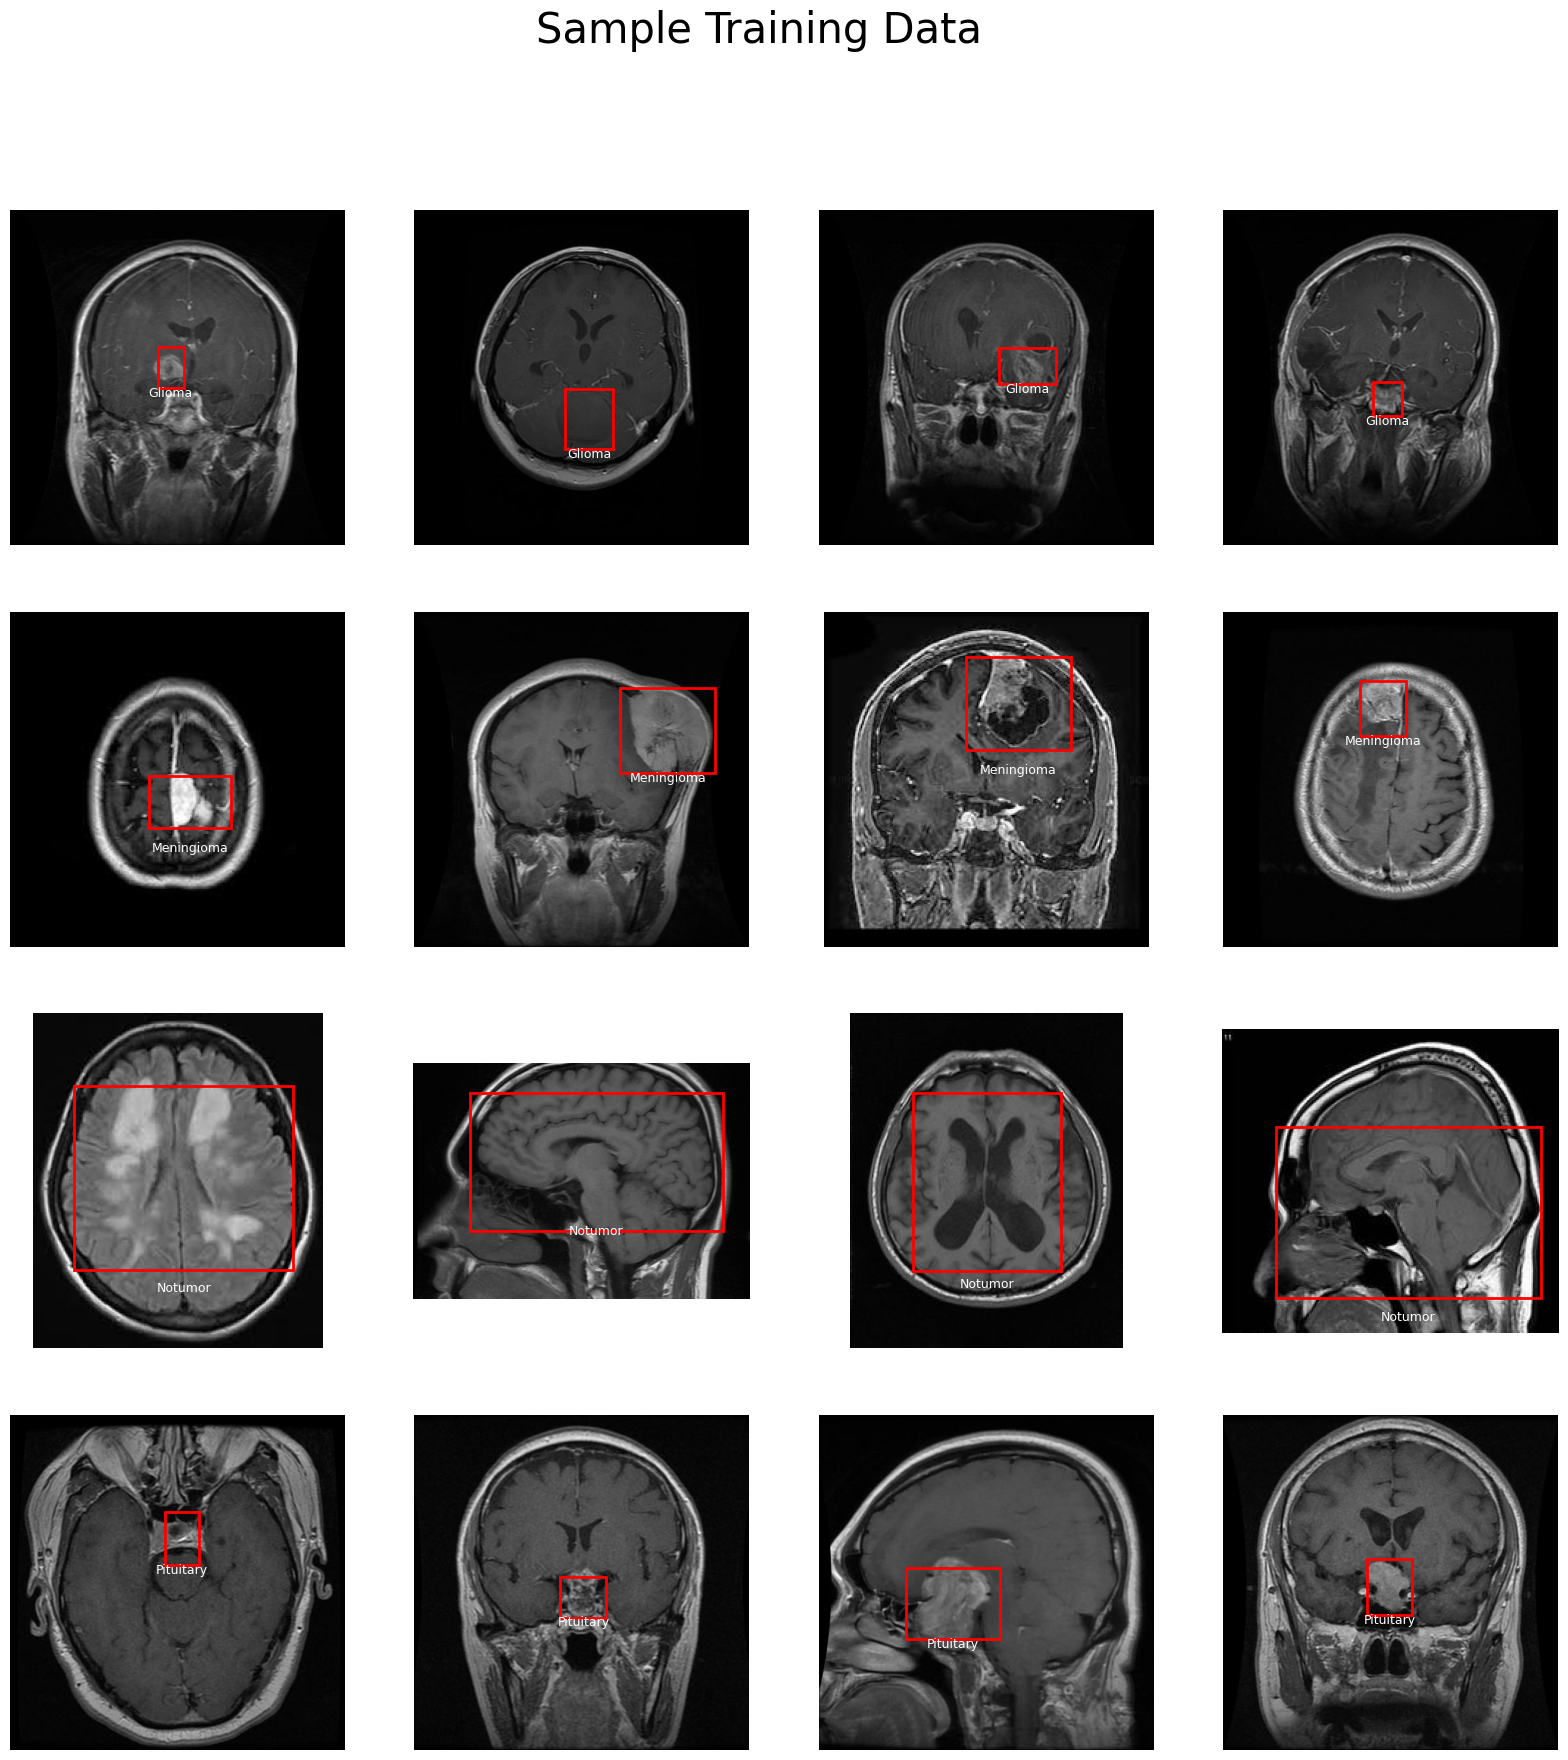

In [9]:
dataset_directory = 'C:/Users/ADMIN/Downloads/Brain Tumor labeled dataset/'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

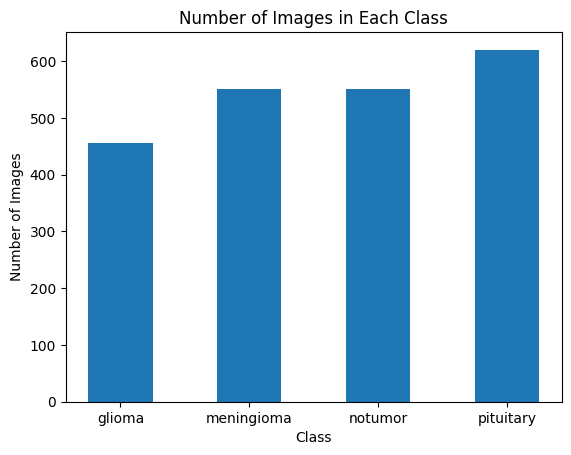

In [10]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [11]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)
     


In [12]:

dataset_directory = 'C:/Users/ADMIN/Downloads/Brain Tumor labeled dataset/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [13]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [14]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

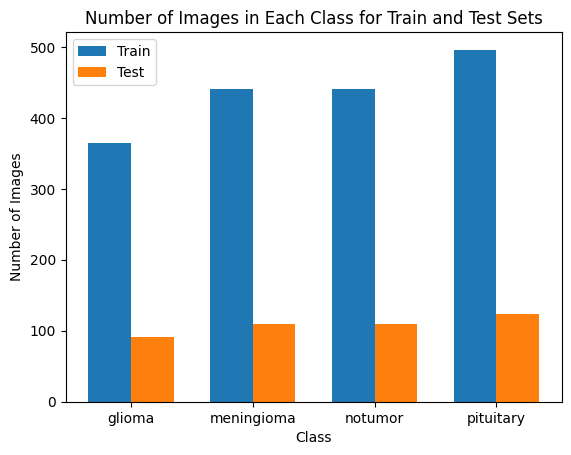

In [15]:
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

In [2]:


from ultralytics import YOLO

# # Initialize the YOLO model with a specified configuration file
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

yolo_btd_model = YOLO('yolov8n.yaml')

# Train the model with the specified dataset and training parameters
yolo_btd_model_results = yolo_btd_model.train(data=r'C:\Users\ADMIN\Downloads\brain_tumor_detection\brain_tumor_dataset.yaml', epochs=10)


Ultralytics YOLOv8.2.91  Python-3.12.5 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6200U 2.30GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:\Users\ADMIN\Downloads\brain_tumor_detection\brain_tumor_dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning C:\Users\ADMIN\Downloads\Brain Tumor labeled dataset\train\glioma.cache... 1740 images, 2 backgrounds, 
val: Scanning C:\Users\ADMIN\Downloads\Brain Tumor labeled dataset\test\glioma.cache... 435 images, 0 backgrounds, 0 co

Plotting labels to runs\detect\train9\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.919       5.44      4.044         12        640: 100%|██████████| 109/109 [40:10<00:00, 2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:11

                   all        435        439   0.000872      0.288     0.0221    0.00675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.429      4.518      3.215         12        640: 100%|██████████| 109/109 [22:31<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:17

                   all        435        439      0.703      0.198       0.19     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.208      3.418      2.743         12        640: 100%|██████████| 109/109 [22:04<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:06

                   all        435        439      0.464      0.414       0.26      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.087       2.71      2.576         12        640: 100%|██████████| 109/109 [22:00<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:13

                   all        435        439      0.573      0.491       0.51      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.95       2.24      2.431         12        640: 100%|██████████| 109/109 [21:32<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:01

                   all        435        439      0.517      0.564      0.539      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.854      1.935      2.327         12        640: 100%|██████████| 109/109 [21:25<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:01

                   all        435        439       0.62      0.629      0.624      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.771      1.747      2.243         12        640: 100%|██████████| 109/109 [21:28<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:01

                   all        435        439      0.681      0.678      0.711      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.728      1.604      2.189         12        640: 100%|██████████| 109/109 [22:13<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:07

                   all        435        439      0.709      0.684      0.729      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.668      1.507      2.134         12        640: 100%|██████████| 109/109 [27:22<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:07

                   all        435        439      0.752       0.66      0.757      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.641      1.418      2.107         12        640: 100%|██████████| 109/109 [25:34<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:21

                   all        435        439      0.812      0.737      0.808      0.438



10 epochs completed in 4.474 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.91  Python-3.12.5 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6200U 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [01:56


                   all        435        439      0.814      0.737      0.808      0.438
                glioma        124        125      0.795      0.888      0.901      0.413
            meningioma        110        110      0.796      0.782      0.862      0.454
               notumor         91         94      0.753      0.389      0.518      0.207
             pituitary        110        110      0.912      0.891      0.949      0.679
Speed: 6.6ms preprocess, 245.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train9


In [3]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('runs/detect/train9/weights/best.pt')

# Evaluate the model on the validation set
results = model.val(data='C:/Users/ADMIN/Downloads/brain_tumor_detection/brain_tumor_dataset.yaml')

# Print the evaluation results
print(results)




Ultralytics YOLOv8.2.91  Python-3.12.5 torch-2.4.1+cpu CPU (Intel Core(TM) i5-6200U 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ADMIN\Downloads\Brain Tumor labeled dataset\test\glioma.cache... 435 images, 0 backgrounds, 0 co
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:37


                   all        435        439      0.809      0.741      0.807      0.438
                glioma        124        125      0.793      0.888      0.901      0.414
            meningioma        110        110      0.795      0.782      0.862      0.454
               notumor         91         94      0.754      0.392      0.518      0.207
             pituitary        110        110      0.891        0.9      0.948      0.679
Speed: 5.9ms preprocess, 204.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002942513BE90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005

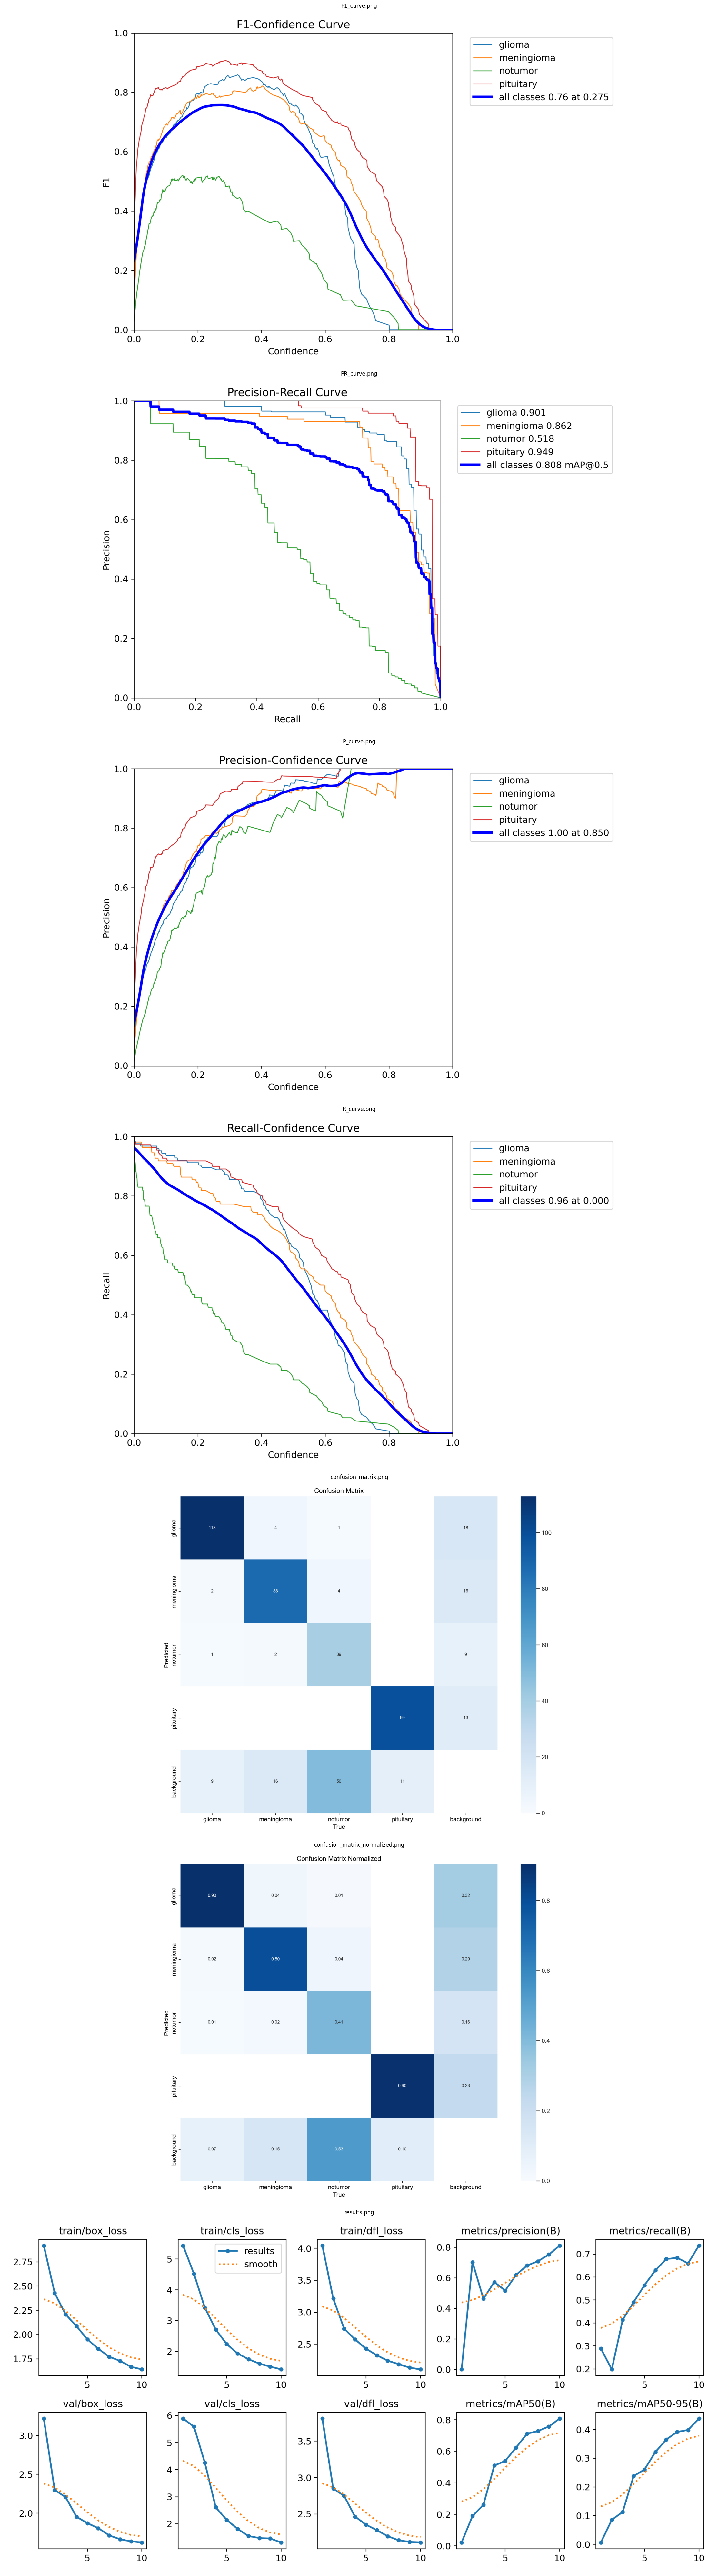

NameError: name 'YOLO' is not defined

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
def plot_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(80, 80))

    for i, ax in enumerate(axes):
        image_path = image_paths[i]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(image_path))

    plt.tight_layout()
    plt.show()
image_paths = [
    'C:/Users/ADMIN/runs/detect/train9/F1_curve.png',
    'C:/Users/ADMIN/runs/detect/train9/PR_curve.png',
    'C:/Users/ADMIN/runs/detect/train9/P_curve.png',
    'C:/Users/ADMIN/runs/detect/train9/R_curve.png',
    'C:/Users/ADMIN/runs/detect/train9/confusion_matrix.png',
    'C:/Users/ADMIN/runs/detect/train9/confusion_matrix_normalized.png',
    'C:/Users/ADMIN/runs/detect/train9/results.png',
]
plot_images(image_paths)



Enter the path to the input image file (e.g., C:\Users\ADMIN\Desktop\tumor.jpg):  C:\Users\ADMIN\Documents\Y17.jpg



image 1/1 C:\Users\ADMIN\Documents\Y17.jpg: 512x512 1 meningioma, 164.8ms
Speed: 3.8ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict2


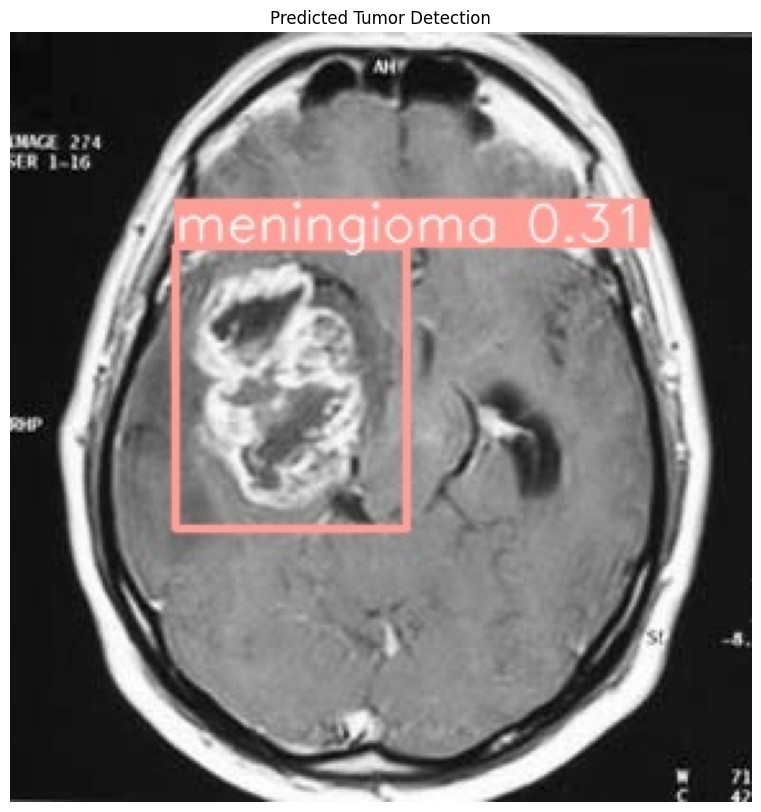

In [3]:
import os
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display_tumor(input_image_path, 
                              model_path="C:\\Users\\ADMIN\\runs\\detect\\train9\\weights\\best.pt", 
                              output_dir='runs/detect/predict', 
                              conf=0.3):
    """
    Predict and display tumor regions using the YOLOv8 model.

    Parameters:
    - input_image_path: Path to the input image file provided by the user.
    - model_path: Path to the trained YOLOv8 weights (.pt file). Defaults to the given model path.
    - output_dir: Directory where YOLO saves predictions. Defaults to 'runs/detect/predict'.
    - conf: Confidence threshold for predictions. Defaults to 0.3.
    """
    # Load the YOLOv8 model
    model = YOLO(model_path)

    # Run prediction on the input image
    results = model.predict(
        source=input_image_path, 
        save=True, 
        imgsz=512, 
        conf=conf, 
        save_dir=output_dir
    )

    # Construct the predicted image path
    predicted_image_path = os.path.join(output_dir, os.path.basename(input_image_path))
    if os.path.exists(predicted_image_path):
        # Open and display the predicted image
        predicted_image = Image.open(predicted_image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(predicted_image)
        plt.axis('off')
        plt.title("Predicted Tumor Detection")
        plt.show()
    else:
        print(f"Error: Predicted image not found in {output_dir}.")

# Main script
if __name__ == "__main__":
    input_image_path = input("Enter the path to the input image file (e.g., C:\\Users\\ADMIN\\Desktop\\tumor.jpg): ")

    if os.path.exists(input_image_path):
        predict_and_display_tumor(input_image_path)
    else:
        print("Error: Invalid image file path. Please check and try again.")



In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import os
from io import BytesIO
import time

# Define the model path
model_path = "C:\\Users\\ADMIN\\runs\\detect\\train9\\weights\\best.pt"

# Load the YOLO model
model = YOLO(model_path)

# Create a file upload widget
upload_widget = widgets.FileUpload(
    accept='.jpg',  # Accept only .jpg files
    multiple=False  # Allow only a single file upload
)

# Create an output widget to display results
output_widget = widgets.Output()

def handle_file_upload(change):
    """Handle the file upload and perform tumor detection."""
    with output_widget:
        clear_output()  # Clear previous output
        # Process the uploaded file
        for fileinfo in upload_widget.value:
            # Read the uploaded image file content
            image_data = BytesIO(fileinfo['content'])
            img = Image.open(image_data)
            
            # Display the uploaded image
            print(f"Uploaded image: {fileinfo['name']}")
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.title("Uploaded Image")
            plt.show()
            
            # Save the uploaded image temporarily
            temp_image_path = os.path.join("C:\\Users\\ADMIN\\Documents", fileinfo['name'])
            img.save(temp_image_path)
            
            # Run prediction using YOLO
            results = model.predict(source=temp_image_path, save=True, imgsz=512, conf=0.3)
            
            # Wait for the prediction to be saved
            time.sleep(1)  # Adjust the sleep time if necessary
            
            # Get the dynamically created output directory (first result)
            result = results[0]  # Results is a list, take the first result
            output_dir = result.save_dir  # This gets the directory where results are saved

            # Define the predicted image path
            predicted_image_path = os.path.join(output_dir, fileinfo['name'])
            
            # Check if the predicted image exists and display it
            if os.path.exists(predicted_image_path):
                predicted_image = Image.open(predicted_image_path)
                
                # Access the predictions
                boxes = result.boxes  # This holds the bounding boxes for detections
                # Extract the predicted class
                if len(boxes) > 0:
                    predicted_class_idx = int(boxes[0].cls[0])  # Get class index of the first box
                    predicted_label = result.names[predicted_class_idx]  # Get class label from the index
                    print(f"Predicted Tumor Detection: {predicted_label}")
                else:
                    predicted_label = "No tumor detected"
                    print(predicted_label)
                
                # Display the predicted image
                plt.figure(figsize=(5, 5))
                plt.imshow(predicted_image)
                plt.axis('off')
                plt.title(f"Prediction Result: {predicted_label}")
                plt.show()
            else:
                print("Error: Predicted image not found. Please check the model output directory.")

# Attach the event handler to the upload widget
upload_widget.observe(handle_file_upload, names='value')

# Display the upload widget and output widget
print("Please upload an image file (.jpg):")
display(upload_widget)
display(output_widget)



Please upload an image file (.jpg):


FileUpload(value=(), accept='.jpg', description='Upload')

Output()